# Maze Detection

In [2]:
import cv2
import time
import numpy as np
from maze_detection import MazeDetector
from with_cv2 import display_video
import threading
import matplotlib.pyplot as plt
from media_utils import capture_image
from seed import isolate_maze_with_reconstruction

def imgShow(title, img):
    """Display image in Jupyter notebook with proper color handling"""
    plt.figure(figsize=(10, 8))
    
    # Check if image is grayscale or color
    if len(img.shape) == 2:
        # Grayscale image
        plt.imshow(img, cmap='gray')
    else:
        # Color image - convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
    
    plt.title(title)
    plt.axis("off")
    plt.show()

# md = MazeDetector()
# cap = cv2.VideoCapture(2)
# time.sleep(1.0)

# threading.Thread(target=display_video, args=(cap,md)).start()

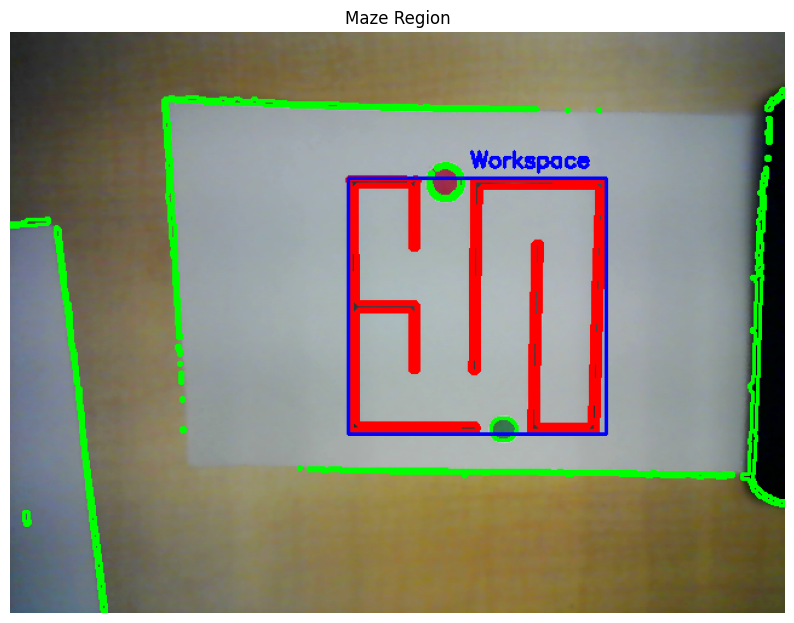

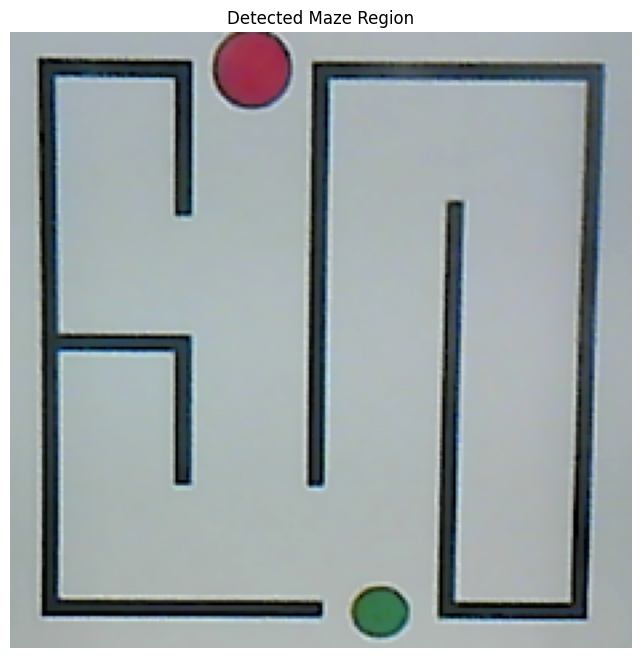

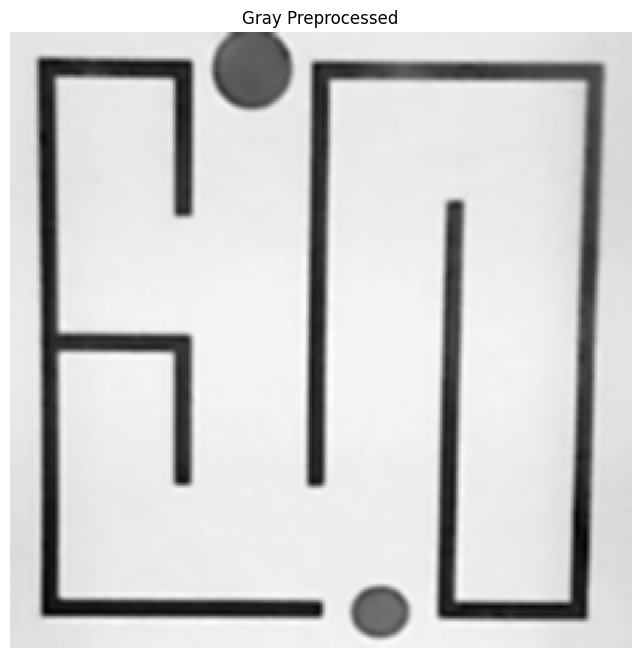

Corners detected: [[117.86487   15.864865]
 [216.54639   17.849485]
 [165.85004  214.26575 ]
 [113.897026 165.2785  ]]


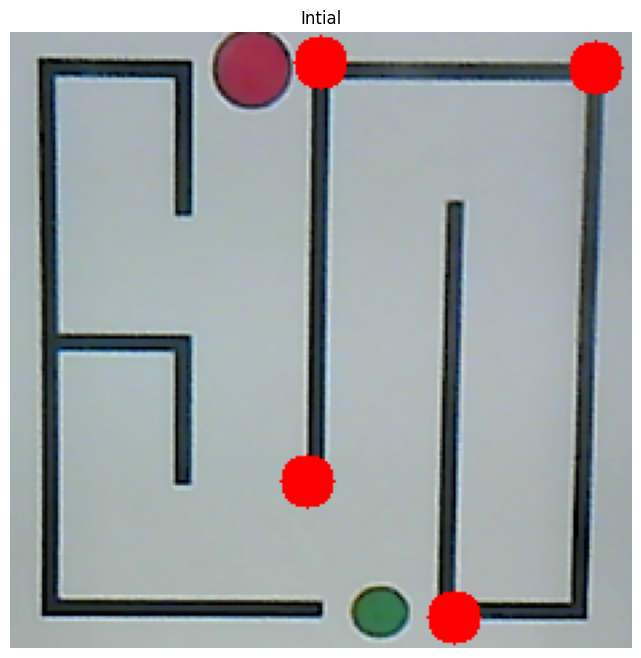

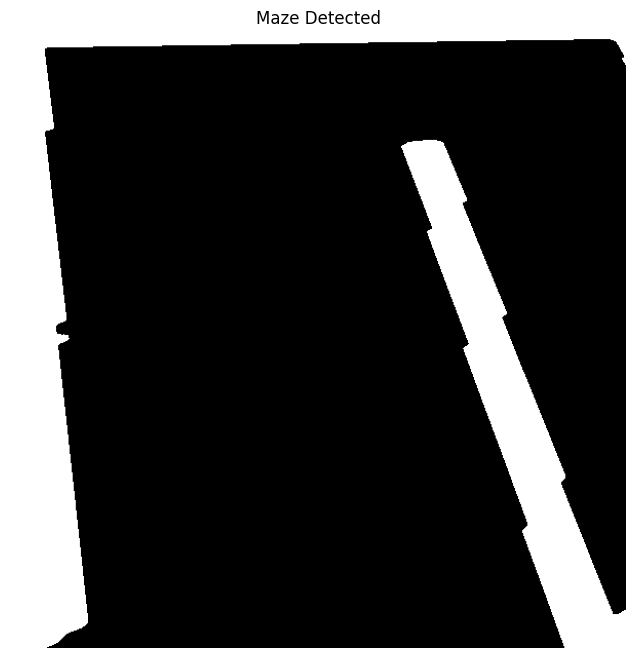

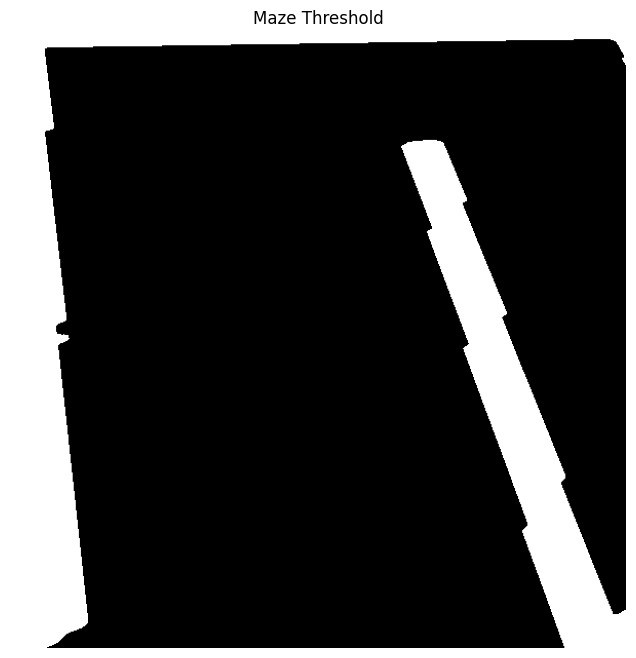

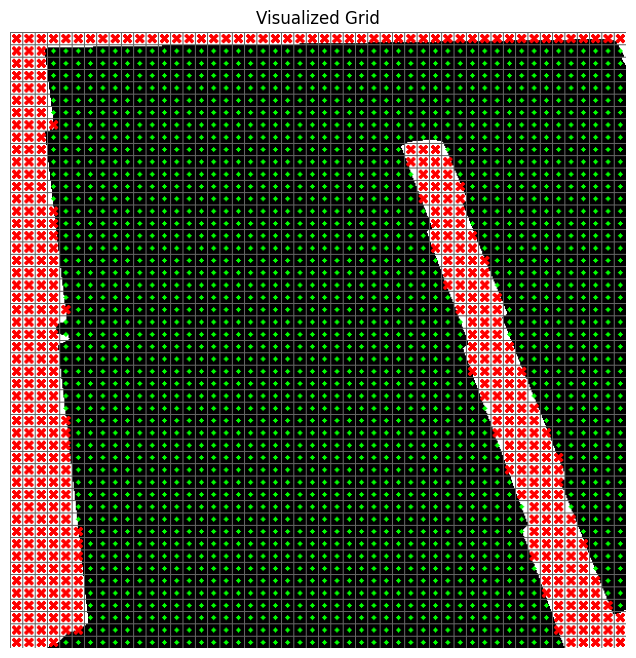

In [5]:
def warp_from_corners(src_gray, corners_xy, out_size=600):
    """
    src_gray: uint8 grayscale image (same one you passed to isolate_maze_with_reconstruction)
    corners_xy: 4x2 float32 array in (x,y) order, TL,TR,BR,BL (already ordered by your function)
    out_size: output square size
    """
    dst = np.float32([[0,0],[out_size,0],[out_size,out_size],[0,out_size]])
    M = cv2.getPerspectiveTransform(corners_xy.astype(np.float32), dst)
    warped = cv2.warpPerspective(src_gray, M, (out_size, out_size))
    return warped

def preprocess_maze(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frame = cv2.GaussianBlur(frame, (5,5), 1)
    # frame = cv2.normalize(frame, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    return frame
# _, frame = capture_image(cap)

def expand_corners(corners, scale=1.03):
    # scale corners about their centroid
    center = np.mean(corners, axis=0)
    expanded = (corners - center) * scale + center
    return expanded.astype(np.float32)


frame = cv2.imread("../maze_dots_plain.png")
# _, frame = capture_image(cap)
# imgShow("Original Frame", frame)


md = MazeDetector()

new_frame, maze_thresh, maze_region, roi = md.detect_maze(frame)

imgShow("Maze Region", new_frame)

imgShow("Detected Maze Region", roi)

processed = preprocess_maze(roi)

imgShow("Gray Preprocessed", processed)

corners, isolated_maze = isolate_maze_with_reconstruction(processed, seed_half=25, second_seed_half=190, bin_thresh=0.5, selem1=(5,5), selem2=(4,4))
print("Corners detected:", corners)
corners = expand_corners(corners, scale=1.05)
for (x, y) in corners:
    if not np.isnan(x) and not np.isnan(y):
        cv2.circle(roi, (int(x), int(y)), 10, (0, 0, 255), -1)
imgShow("Intial",roi)

warped_maze = warp_from_corners(isolated_maze, corners, out_size=600)

# warped_blur   = cv2.GaussianBlur(warped_maze, (5,5), 0)
# warped_thresh = cv2.adaptiveThreshold(
#     warped_blur, 255,
#     cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#     cv2.THRESH_BINARY_INV,
#     11, 2
# )
_, warped_thresh = cv2.threshold(
    warped_maze, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
)

# grid = md.maze_to_grid(maze_thresh, 50)

# visual = md.visualize_grid(maze_thresh, grid)

# imgShow("Maze Detected", new_frame)
# imgShow("Maze Threshold", maze_thresh)
# imgShow("Visualized Grid", visual)

grid = md.maze_to_grid(warped_thresh, 50)

visual = md.visualize_grid(warped_thresh, grid)

cv2.imwrite("warped_maze.png", warped_thresh)
cv2.imwrite("visualized_grid.png", visual)

imgShow("Maze Detected", warped_thresh)
imgShow("Maze Threshold", warped_thresh)
imgShow("Visualized Grid", visual)

In [9]:
print("Maze Grid:")
print(grid)

Maze Grid:
[[0 0 0 ... 0 0 0]
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 ...
 [0 1 1 ... 1 1 0]
 [0 1 1 ... 1 1 0]
 [0 0 0 ... 0 0 0]]


# Camera Calibration

In [ ]:
image_list = ["../chess1.png", "../chess2.png", "../chess3.png",
              "../chess4.png", "../chess5.png", "../chess6.png",
              "../chess7.png", "../chess8.png", "../chess9.png",
              "../chess10.png", "../chess11.png", "../chess12.png",
              "../chess13.png", "../chess14.png", "../chess15.png",
              "../chess16.png", "../chess17.png"] 
import cv2 as cv
import numpy as np
import glob

# Number of internal corners (squares - 1)
CHECKERBOARD = (3, 3)

# Prepare 3D points for one view
square_size = 0.030  # meters (25 mm squares)
objp = np.zeros((CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
objp *= square_size

objpoints = []
imgpoints = []

for fname in image_list:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(gray, CHECKERBOARD, None)
    if ret:
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1),
                                   (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        imgpoints.append(corners2)
        objpoints.append(objp)
        cv.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
        cv.imshow("Corners", img)
        cv.waitKey(500)
    else:
        print("No corners found in", fname)

cv.destroyAllWindows()

if len(objpoints) > 0:
    ret, K, d, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print("Reprojection error:", ret)
    np.save("camera_matrix.npy", K)
    np.save("dist_coeffs.npy", d)
else:
    print("No valid images! Check pattern or lighting.")



Reprojection error: 0.1814968826050468


In [1]:
img = cv.imread("../chess10.png")
img_undistorted = cv.undistort(img, K, d)
imgShow("undistorted", img_undistorted)

NameError: name 'cv' is not defined

In [ ]:
import cv2 as cv
import numpy as np

# ---------- load camera intrinsics ----------
K = np.load("camera_matrix.npy")
d = np.load("dist_coeffs.npy")

# ---------- marker & detector setup ----------
tag_size = 0.10  # meters (edge length of your printed marker)
aruco = cv.aruco
dict_ = aruco.getPredefinedDictionary(aruco.DICT_4X4_100)
detector = aruco.ArucoDetector(dict_, aruco.DetectorParameters())

# ---------- video capture ----------
cap = cv.VideoCapture(2)
cap.set(cv.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv.CAP_PROP_FRAME_HEIGHT, 480)
win_name = "Aruco Detection"

# ---------- 3D model points of the square tag (origin at center) ----------
s = tag_size / 2.0
objp = np.array([
    [-s,  s, 0],   # top-left
    [ s,  s, 0],   # top-right
    [ s, -s, 0],   # bottom-right
    [-s, -s, 0]    # bottom-left
], dtype=np.float32)

print("Press ESC to quit.")
while True:
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame. Exiting...")
        break

    # ---------- undistort ----------
    frame_undistorted = cv.undistort(frame, K, d)

    # ---------- detect markers ----------
    corners, ids, _ = detector.detectMarkers(frame_undistorted)

    if ids is not None:
        # draw detection outlines
        aruco.drawDetectedMarkers(frame_undistorted, corners, ids)

        for i, c in enumerate(corners):
            imgp = c.reshape(-1, 2).astype(np.float32)

            # ---------- pose estimation ----------
            ok, rvec, tvec = cv.solvePnP(
                objp, imgp, K, d, flags=cv.SOLVEPNP_IPPE_SQUARE
            )

            if ok:
                # draw coordinate axes (each axis = 0.05 m)
                cv.drawFrameAxes(frame_undistorted, K, d, rvec, tvec, 0.05)

                # print translation vector (marker center in camera frame)
                t = tvec.ravel()
                # print(f"ID {ids[i][0]} → X:{t[0]:.3f} m  Y:{t[1]:.3f} m  Z:{t[2]:.3f} m")

    # ---------- display ----------
    cv.imshow(win_name, frame_undistorted)
    if cv.waitKey(1) == 27:  # ESC
        break

cap.release()
cv.destroyAllWindows()


Press ESC to quit.
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/ibraheem/ras545/.venv/lib/python3.13/site-packages/cv2/qt/plugins"


ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 m  Y:-0.065 m  Z:0.292 m
ID 0 → X:-0.096 

In [1]:
import numpy as np
import cv2 as cv

def pixel_to_world(u, v, K, rvec, tvec, plane_z=0.0):
    """
    Convert pixel (u, v) into 3D world coordinates assuming the world plane Z = plane_z.
    Inputs:
        u, v       : pixel coordinates
        K          : camera intrinsic matrix (3x3)
        rvec, tvec : pose of the world/camera from solvePnP (tag->camera or camera->world)
        plane_z    : Z value of the target plane in world frame
    Returns:
        np.array([Xw, Yw, Zw]) in meters
    """
    # get rotation and camera position
    R, _ = cv.Rodrigues(rvec)
    R_wc = R.T                      # world <- camera rotation
    t_wc = -R_wc @ tvec             # camera origin in world coordinates

    # back-project pixel ray
    uv_h = np.array([u, v, 1.0])
    ray_c = np.linalg.inv(K) @ uv_h
    ray_w = R_wc @ ray_c

    # compute intersection with Z = plane_z
    s = (plane_z - t_wc[2]) / ray_w[2]
    Pw = t_wc + s * ray_w
    return Pw.ravel()


# Maze Solving

## Path Finding

In [20]:
from openai import OpenAI
import base64
import cv2
from dotenv import load_dotenv
import os
import json
from pydantic import BaseModel, Field
from typing import List

load_dotenv()

client = OpenAI()


class Waypoint(BaseModel):
    x: int = Field(..., description="x-coordinate of the waypoint in image pixels")
    y: int = Field(..., description="y-coordinate of the waypoint in image pixels")

class MazePath(BaseModel):
    entrance: Waypoint = Field(..., description="Entrance point (open cell on maze border)")
    exit: Waypoint = Field(..., description="Exit point (open cell on opposite border)")
    path: List[Waypoint] = Field(..., description="Ordered list of waypoints from entrance to exit")


def maze_to_waypoints_structured(image_path: str) -> MazePath:
    """
    Uses GPT-4o to:
      • detect maze entrance & exit automatically
      • compute the shortest path (4-directional)
      • return a validated MazePath object
    """

    with open(image_path, "rb") as f:
        img_b64 = base64.b64encode(f.read()).decode("utf-8")

    prompt = """
You are an expert in computer vision and pathfinding.
You will receive a binary maze image (white = walls, black = walkable paths).

Tasks:
1. Identify the entrance and exit automatically — the open black pixels along the outer border.
2. Compute the shortest valid path from entrance to exit.
   - Only 4-way movement (up, down, left, right) along black pixels.
3. Return the data in the exact structure requested.
    """

    response = client.responses.parse(
        model="gpt-5",   
        input=[
            {
                "role": "user",
                "content": [
                    {"type": "input_text", "text": prompt},
                    {"type": "input_image", "image_url": f"data:image/png;base64,{img_b64}"},
                ],
            }
        ],
        text_format=MazePath,  # <-- the Pydantic schema we defined
    )

    maze_solution: MazePath = response.output_parsed
    return maze_solution

maze_solution = maze_to_waypoints_structured("warped_maze.png")

print("Entrance:", maze_solution.entrance)
print("Exit:", maze_solution.exit)
print("Path length:", len(maze_solution.path))
print("First 5 waypoints:", maze_solution.path[:5])

import cv2

img = cv2.imread("warped_maze.png")
for wp in maze_solution.path:
    cv2.circle(img, (wp.x, wp.y), 2, (0, 0, 255), -1)

cv2.circle(img, (maze_solution.entrance.x, maze_solution.entrance.y), 5, (0, 255, 0), -1)
cv2.circle(img, (maze_solution.exit.x, maze_solution.exit.y), 5, (255, 0, 0), -1)

cv2.imwrite("maze_solved.png", img)


Entrance: x=298 y=0
Exit: x=541 y=599
Path length: 935
First 5 waypoints: [Waypoint(x=298, y=0), Waypoint(x=298, y=1), Waypoint(x=298, y=2), Waypoint(x=298, y=3), Waypoint(x=298, y=4)]


True

# Maze Detection without using LLM

In [12]:
grid.shape

(50, 50)

In [8]:
import heapq

def astar_search(maze_grid, start, goal):
    """
    Perform A* search on a binary maze grid.
    maze_grid: 2D numpy array (0=free, 1=wall)
    start, goal: (row, col) tuples
    Returns: list of (row, col) waypoints in shortest path, or [] if no path found.
    """

    # Basic setup
    rows, cols = maze_grid.shape
    start, goal = tuple(start), tuple(goal)

    # Check bounds
    if maze_grid[start] == 1 or maze_grid[goal] == 1:
        print("Start or goal is blocked.")
        return []

    # Heuristic: Manhattan distance
    def heuristic(a, b):
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    # Priority queue of (f_score, g_score, node, path)
    open_list = []
    heapq.heappush(open_list, (0 + heuristic(start, goal), 0, start, [start]))

    visited = set()

    while open_list:
        f, g, current, path = heapq.heappop(open_list)

        if current == goal:
            return path  # success

        if current in visited:
            continue
        visited.add(current)

        r, c = current

        # Explore 4 neighbors (no diagonals)
        for dr, dc in [(1,0), (-1,0), (0,1), (0,-1)]:
            nr, nc = r + dr, c + dc
            if 0 <= nr < rows and 0 <= nc < cols and maze_grid[nr, nc] == 0:
                if (nr, nc) not in visited:
                    new_g = g + 1
                    f_score = new_g + heuristic((nr, nc), goal)
                    heapq.heappush(open_list, (f_score, new_g, (nr, nc), path + [(nr, nc)]))

    return []  # no path


In [14]:
# Automatically detect start and goal (first and last open cell on edges)
def find_entry_exit(grid):
    rows, cols = grid.shape
    openings = []

    # Top/bottom edges
    for c in range(cols):
        if grid[0, c] == 0:
            openings.append((0, c))
        if grid[rows-1, c] == 0:
            openings.append((rows-1, c))

    # Left/right edges
    for r in range(rows):
        if grid[r, 0] == 0:
            openings.append((r, 0))
        if grid[r, cols-1] == 0:
            openings.append((r, cols-1))

    if len(openings) < 2:
        raise ValueError("Could not find two openings on maze edges.")
    return openings[0], openings[-1]

start, goal = find_entry_exit(grid)
print("Start:", start, "Goal:", goal)

# Solve
path = astar_search(grid, start, goal)
print("Path length:", len(path))

cell_h = warped_thresh.shape[0] / grid.shape[0]
cell_w = warped_thresh.shape[1] / grid.shape[1]

for (r, c) in path:
    cx = int((c + 0.5) * cell_w)
    cy = int((r + 0.5) * cell_h)
    cv2.circle(visual, (cx, cy), 3, (255, 0, 0), -1)

cv2.imshow("A* Path", visual)
cv2.waitKey(0)



Start: (0, 21) Goal: (49, 28)
Path length: 81


qt.qpa.plugin: Could not find the Qt platform plugin "wayland" in "/home/ibraheem/ras545/.venv/lib/python3.13/site-packages/cv2/qt/plugins"


27

In [1]:

# Step 2. Convert grid cells → image pixels
cell_h = warped_thresh.shape[0] / grid.shape[0]
cell_w = warped_thresh.shape[1] / grid.shape[1]
path_pixels = [(int((c + 0.5) * cell_w), int((r + 0.5) * cell_h)) for (r, c) in path]

# Step 3. Convert pixels → world coordinates
path_world = [pixel_to_world(x, y, K, rvec, tvec, plane_z=0.0) for (x, y) in path_pixels]


NameError: name 'warped_thresh' is not defined

### Test OpenAI Client

In [8]:
response = client.responses.create(
    model="gpt-4o", 
    input=[
        {
            "role": "user",
            "content": [
                {"type": "input_text", "text": "Ay yo just checking in"}
            ]
        }
    ]
)

print(response)

Response(id='resp_0c9e5614bc13d9f50068f9ca36a6e4819385e953577e4a6ac0', created_at=1761200694.0, error=None, incomplete_details=None, instructions=None, metadata={}, model='gpt-4o-2024-08-06', object='response', output=[ResponseOutputMessage(id='msg_0c9e5614bc13d9f50068f9ca3869408193ab2fb695332868db', content=[ResponseOutputText(annotations=[], text="Hey! What's up? How's everything going?", type='output_text', logprobs=[])], role='assistant', status='completed', type='message')], parallel_tool_calls=True, temperature=1.0, tool_choice='auto', tools=[], top_p=1.0, background=False, conversation=None, max_output_tokens=None, max_tool_calls=None, previous_response_id=None, prompt=None, prompt_cache_key=None, reasoning=Reasoning(effort=None, generate_summary=None, summary=None), safety_identifier=None, service_tier='default', status='completed', text=ResponseTextConfig(format=ResponseFormatText(type='text'), verbosity='medium'), top_logprobs=0, truncation='disabled', usage=ResponseUsage(inp

# Move Dobot

In [1]:
import pydobot

In [2]:
device = pydobot.Dobot(port='/dev/ttyACM0')

Clearing alarms: 0.


In [3]:
device.home()

6

# Detect Corners

In [7]:
from skimage.morphology import reconstruction
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import numpy as np
from skimage.util import invert
from skimage.morphology import binary_erosion
from skimage.morphology.convex_hull import convex_hull_image
from skimage.feature import corner_harris, corner_subpix


maze = imread('../maze_dots.png', as_gray=True)
h, w = maze.shape

#creating the seed 
seed = np.zeros_like(maze)
size = 40

#we create a window in the center of the image
seed[h//2-size:h//2+size, w//2-size:w//2+size] = maze[h//2-size:h//2+size, w//2-size:w//2+size]

rec_1 = reconstruction(seed, maze)
rec_1[rec_1 < 0.70] = 0.
rec_1[rec_1 >= 0.70] = 1.

seed_2 = np.ones_like(rec_1)
size_2 = 240
seed_2[h//2-size_2:h//2+size_2, w//2-size_2:w//2+size_2] = reconstruction[h//2-size_2:h//2+size_2, w//2-size_2:w//2+size_2]
rec_2 = reconstruction(seed_2, rec_1, method='erosion', selem=np.ones((11,11)))

rec_2_inv = invert(rec_2)
hull = convex_hull_image(rec_2_inv)
hull_eroded = binary_erosion(hull, selem=np.ones(30,30))

coords = corner_peaks(corner_harris(hull_eroded), min_distance=5, threshold_rel=0.02)
coords_subpix = corner_subpix(rec_2_inv, coords, window_size=13)[2:4]

fig, ax = plt.subplots()
ax.imshow(rec_2_inv, cmap=plt.cm.gray)
ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
plt.savefig('maze_with_coordinates.png', bbox_tight=True)

TypeError: 'function' object is not subscriptable